# Analyze Eye Gaze Data

In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pickle
from statsmodels.robust.scale import mad
from utils import *

from eye_gaze_analysis import *

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
user_info_df = pd.read_csv('adhd_eye_movement_data/user_info.csv')
user_info_df.iloc[a.index[a['Subject'] == 3][0]]['Group']

'off-ADHD'

In [37]:
user_info_df

,Subject,Age,Group
0,1,10,off-ADHD
1,2,9,off-ADHD
2,3,9,off-ADHD
3,4,12,off-ADHD
4,5,10,off-ADHD
...,...,...,...
62,46,12,Ctrl
63,47,11,Ctrl
64,48,12,Ctrl
65,49,9,Ctrl


# Data Preprocessing

## Heuristic Spike Filter + Signal Loss + Noise Reduction

In [43]:
def classifySubjectN(n):
    # Input: subject number
    # Output: EyegazeClassifier call output on preprocessed data for specified trial number
    subject_raw_data = load_raw_data(n)
    #subject_trials = np.concatenate(extract_trials(subject_raw_data)[:, [2,3]])

    # Eye Gaze Analysis Preprocessing
    clf = EyegazeClassifier(px2deg=deg_per_pixel(50.8, 60, 1920))
    subject_data = {'x': subject_raw_data['Position_1'].to_numpy(), 'y': subject_raw_data['Position_2'].to_numpy()}
    events = clf(clf.preproc(subject_data), classify_isp=False)
    return events

def congregateSubjectDataN(n):
    # Input: Subject Number
    # Output: Summary data for all trials
    res = []
    for i in range(160):
        # Assumption of 160 trials! Must change if number changes
        res.append(classifySubjectN(n, i))
    return res

def congregateSpecific(n, field):
    res = []
    for i in range(160):
        res.append([d for d in classifySubjectN(n, i) if d['label'] == field][0])
    return res

def congregateSpecificMeasurement(n, field, measurement):
    res = []
    for i in range(160):
        intermediate = [d for d in classifySubjectN(n, i) if d['label'] == field]
        if not len(intermediate):
            # This behavior skips trials where field of interest is not produced for example 'SACC' is not available
            continue
        dictionary = intermediate[0]
        res.append(dictionary[measurement])
    return res

In [ ]:
for i in user_info_df['Subject']:
    store_pickle(classifySubjectN(i), "events_data/subject_{}_events.pkl".format(i))

In [ ]:
adhd_pos_events = []
adhd_neg_events = []
for i in range(1, 51):
    data = load_pickle("events_data/subject_{}_events.pkl".format(i))
    if 'off-ADHD' in user_info_df[user_info_df['Subject'] == i]['Group'].to_list():
        adhd_pos_events.append(data)
    
    if 'Ctrl' in user_info_df[user_info_df['Subject'] == i]['Group'].to_list():
        adhd_neg_events.append(data)

In [102]:
from scipy import stats

def get_event_metrics(data, event_type, event_metric):
    x = np.array([e[event_metric] for e in data if e['label'] == event_type])
    return x[~np.isnan(x)]

In [103]:
adhd_pos_max_avg_vel = [np.max(get_event_metrics(e, 'SACC', 'avg_vel')) for e in adhd_pos_events if len(e) > 0]
adhd_neg_max_avg_vel = [np.max(get_event_metrics(e, 'SACC', 'avg_vel')) for e in adhd_neg_events if len(e) > 0]

In [104]:
p_val = stats.mannwhitneyu(adhd_pos_max_avg_vel, adhd_neg_max_avg_vel)[1]
p_val

0.02759745819082515

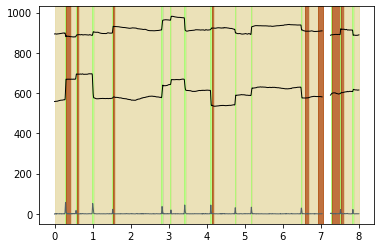

In [40]:
clf.show_gaze(pp=clf.preproc(data), events=events)

In [ ]:
filtered_x = heuristic_spike_filter(raw_x)
plt.plot(filtered_x)

In [ ]:
filtered_y = heuristic_spike_filter(raw_y)
plt.plot(filtered_y)

In [ ]:
# Euclidean distance
# Input: (x1, y1), (x2, y2)
def euclidean_dist(point1, point2):
    return np.sqrt(np.square(point1[0] - point2[0]) + np.square(point1[1] - point2[1]))

# Point-to-point velocity
# Input: (x1, y1), (x2, y2)
def ptp_velocity(point1, point2, t1, t2):
    return euclidean_dist(point1, point2) / (t2 - t1)

# Point-to-point velocities for a given interval
# Input: df 
def ptp_velocities(data):
    velocities = []
    for idx, row in data.iterrows():
        if idx + 1 < len(data):
            pass

print(euclidean_dist(5, 0, 100, 0))
print(ptp_velocity(5, 0, 100, 0, 5, 10))

# Scanpath Analysis

In [ ]:
plt.plot(test['Position_1'], test['Position_2'])

In [ ]:
plt.plot(fetch_data(45)['Position_1'], fetch_data(45)['Position_2'])

In [ ]:
test.where(test['Events'])